# BNS Postmerger GW Representations

This notebook explores the time-, frequency- and time-frequency representations of BNS merger/post-merger signals


In [73]:
# %matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import sys, os, h5py
import cPickle as pickle
import numpy as np
from matplotlib import pyplot as plt
import lal
import cwt

import pycbc.waveform as wfutils
from pycbc.waveform import get_td_waveform,taper_timeseries
from pycbc.types import FrequencySeries
from pycbc.filter import sigma as optimal_snr

fig_width_pt = 510.
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

fontsize = 16
legendfontsize = 14

params={'text.usetex': True,
        'axes.labelsize': fontsize,
        'text.fontsize': fontsize,
        'legend.fontsize': legendfontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.figsize': fig_size,
        'font.weight': 'normal'
       }


import pylab
pylab.rcParams.update(params)
pylab.rcParams['axes.linewidth'] = 1
pylab.rc('axes', linewidth=1)

def touchbox(ax):
    ax.tick_params('both', length=5, width=1, which='major')
    ax.tick_params('both', length=3.5, width=1, which='minor')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    return


## Data aquisition

### Notebook configuration
working & save directories, filenames etc

In [74]:
workdir="/work/BNS-bursts/utils"
waveform_dir="/work/lvcnr-matter/BNS/bauswein"
savepath = workdir

sample_frequency = 16384

### Detector configuration
Choice, names of IFOs, ...

In [75]:
noise_curves="ADE_noise_curves.pickle"
ifos = ['aLIGO','ETD','CE1']
ifonames=[r'$\mathrm{aLIGO}$',r'$\mathrm{Einstein}$', r'$\mathrm{Cosmic Explorer}$']

### Waveform configuration
Choice of waveform (filename), EOS, masses, ...
Note that the name convention below only applies to Bauswein waveforms; we'll need a different routine for Trento/Frankfurt

In [106]:
EOS="NL3"
mass=(1.9,1.9)

# Construct waveform label: EOS(lower case)_mass1mass2.h5
if EOS=="DD2":
    wavelabel=EOS.lower()+"new_"+"".join(
        [str(component).replace(".","") for component in mass]
    )
else:
    wavelabel=EOS.lower()+"_"+"".join(
        [str(component).replace(".","") for component in mass]
    )

numrel_data=os.path.join(waveform_dir,wavelabel+'.h5')

if os.path.exists(numrel_data):
    print "HDF5 {} located".format(numrel_data)
else:
    print "HDF5 {} non-existent".format(numrel_data)
    sys.exit()


HDF5 /work/lvcnr-matter/BNS/bauswein/nl3_1919.h5 located


## Generate Waveforms


In [107]:
f = h5py.File(numrel_data, 'r')


hp, hc = get_td_waveform(approximant='NR_hdf5',
                                 numrel_data=numrel_data,
                                 mass1=f.attrs['mass1']*sum(mass),
                                 mass2=f.attrs['mass2']*sum(mass),
                                 spin1z=f.attrs['spin1z'],
                                 spin2z=f.attrs['spin2z'],
                                 delta_t=1.0/sample_frequency,
                                 f_lower=10.,
                                 inclination=0.0,
                                 coa_phase=0.0,
                                 distance=100)

f.close()

# Resize / zero-pad to 10 seconds
hp.resize(10*sample_frequency)
hc.resize(10*sample_frequency)

# Truncate and taper from maximum
delay=0#int(1e-3 / delta_t)
truncidx = np.argmax(abs(hp)) - delay
import copy
hp_post = copy.deepcopy(hp)
hp_post.data[:truncidx] = 0.0 
hc_post = copy.deepcopy(hc)
hc_post.data[:truncidx] = 0.0 

# taper waveform
hp = taper_timeseries(hp, tapermethod="TAPER_STARTEND")
hc = taper_timeseries(hc, tapermethod="TAPER_STARTEND")

hp_post = taper_timeseries(hp_post, tapermethod="TAPER_STARTEND")
hc_post = taper_timeseries(hc_post, tapermethod="TAPER_STARTEND")


## Noise spectra
Load spectra into pycbc frequency series for easy SNR calculations
 * Use sample frequencies (0,$F_{\mathrm{Ny}}$) Hz
 * Interpolate each noise curve to those frequencies

Remember to set the low-frequency cutoff appropriately (higher than the inital frequency of the noise curves) for any calculations involving integration over frequency


In [108]:
noise_spectra = pickle.load(open(os.path.join(workdir,noise_curves)))
sample_frequencies = noise_spectra['sample_frequencies']
frequencies = np.arange(0,0.5*sample_frequency+0.1,0.1)

aLIGO = FrequencySeries(np.interp(frequencies, sample_frequencies, 
                                noise_spectra['aLIGO']**2), delta_f=0.1)
ETD = FrequencySeries(np.interp(frequencies, sample_frequencies, 
                                noise_spectra['ET-D']**2), delta_f=0.1)
CE1 = FrequencySeries(np.interp(frequencies, sample_frequencies, 
                                noise_spectra['CE1']**2), delta_f=0.1)

### Characterize waveform
SNR, characteristic frequency, etc

In [109]:
# Amplitude spectra
Hp = hp.to_frequencyseries()
Hp_post = hp_post.to_frequencyseries()
norm = 4*Hp.delta_f

amplitude = wfutils.amplitude_from_polarizations(hp,hc)
frequency = wfutils.frequency_from_polarizations(hp,hc)

amplitude_post = wfutils.amplitude_from_polarizations(hp_post,hc_post)
frequency_post = wfutils.frequency_from_polarizations(hp_post,hc_post)

contact_frequency = frequency[np.argmax(amplitude)]
print contact_frequency

# SNR>1kHz
SNR1000 = optimal_snr(Hp, aLIGO, low_frequency_cutoff=1000.)
print SNR1000

# SNR of time-domain windowed signal
SNRpost = optimal_snr(Hp_post, aLIGO)
print SNRpost

# SNR>contact
SNRcontact = optimal_snr(Hp, aLIGO, low_frequency_cutoff=contact_frequency)
print SNRcontact


# Sanity check normalization:
SNRalt = 4*sum(Hp/np.sqrt(aLIGO.data)*np.conj(Hp/np.sqrt(aLIGO.data)))*Hp.delta_f
print np.sqrt(SNRalt.real)



1603.7074063580772
2.08576857269
0.974813066414
1.13645200769
2.53648066371685


### Some useful derived quantities for plotting

In [110]:
time = hp.sample_times - hp.sample_times[np.argmax(abs(hp))]



### Time domain strain amplitude

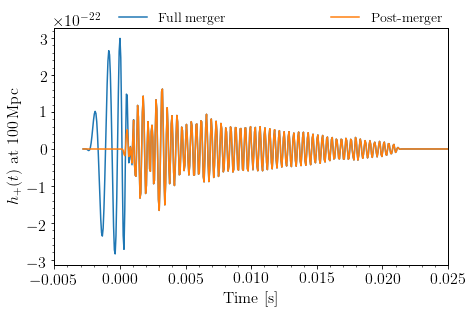

In [111]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(time, hp, label=r'$\textrm{Full merger}$')
ax.plot(time, hp_post, label=r'$\textrm{Post-merger}$')
ax.set_xlabel(r'$\textrm{Time [s]}$')
ax.set_ylabel(r'$h_+(t)\textrm{ at 100\,Mpc}$')
ax.set_xlim(-0.005,0.025)
ax.minorticks_on()
ax.legend(bbox_to_anchor=(0.15, .99, .85, .102), 
                      loc=3, ncol=2, mode="expand", 
                      borderaxespad=0., frameon=False)

plt.savefig("{}-TimeDomain.pdf".format(wavelabel))

plt.show()

### Fourier spectrum

#### Fourier Amplitudes

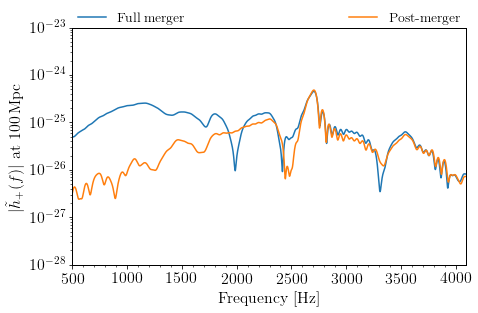

In [112]:
fig, ax = plt.subplots(figsize=fig_size)
ax.semilogy(frequencies, 
            wfutils.amplitude_from_frequencyseries(Hp), 
            label=r'$\textrm{Full merger}$')
ax.semilogy(frequencies, 
            wfutils.amplitude_from_frequencyseries(Hp_post), 
            label=r'$\textrm{Post-merger}$')
ax.minorticks_on()
ax.set_xlabel(r'$\textrm{Frequency [Hz]}$')
ax.set_ylabel(r'$|\tilde{h}_+(f)|\textrm{ at 100\,Mpc}$')
ax.set_xlim(500, 4096)
ax.set_ylim(1e-28,1e-23)
ax.legend(bbox_to_anchor=(0., .99, 1., .102), 
                      loc=3, ncol=2, mode="expand", 
                      borderaxespad=0., frameon=False)

plt.savefig("{}-FourierAmplitudes.pdf".format(wavelabel))

plt.show()

#### Fourier Phase

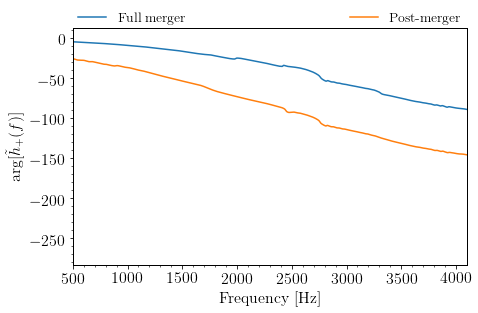

In [113]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(frequencies, 
            wfutils.phase_from_frequencyseries(Hp), 
            label=r'$\textrm{Full merger}$')
ax.plot(frequencies, 
            wfutils.phase_from_frequencyseries(Hp_post), 
            label=r'$\textrm{Post-merger}$')
ax.minorticks_on()
ax.set_xlabel(r'$\textrm{Frequency [Hz]}$')
ax.set_ylabel(r'$\arg[\tilde{h}_+(f)]$')
ax.set_xlim(500, 4096)
# ax.set_ylim(1e-28,1e-23)
ax.legend(bbox_to_anchor=(0., .99, 1., .102), 
                      loc=3, ncol=2, mode="expand", 
                      borderaxespad=0., frameon=False)

plt.savefig("{}-FourierPhases.pdf".format(wavelabel))

plt.show()

### Detectability Spectrum 2*H(f)*sqrt(f)
Overlay Fourier amplitudes with noise curves to assess detectability

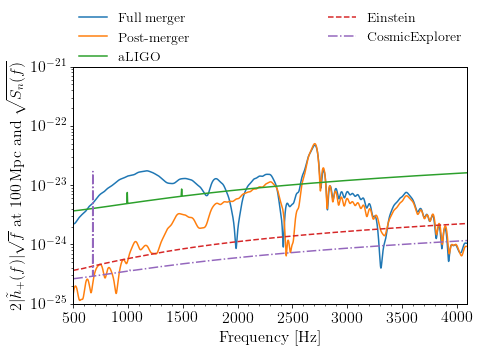

In [114]:
from itertools import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

fig, ax = plt.subplots(figsize=fig_size)

ax.semilogy(frequencies, 2*abs(Hp)*np.sqrt(frequencies),
           label=r'$\textrm{Full merger}$')
ax.semilogy(frequencies, 2*abs(Hp_post)*np.sqrt(frequencies),
           label=r'$\textrm{Post-merger}$')

for c,curve in enumerate([aLIGO, ETD, CE1]):
    ax.semilogy(frequencies,np.sqrt(curve), 
                linestyle=next(linecycler), label=ifonames[c])
    
ax.set_xlabel(r'$\textrm{Frequency [Hz]}$')
ylabel=r'$2|\tilde{h}_+(f)|\sqrt{f}\textrm{ at 100\,Mpc}\textrm{ and }\sqrt{S_n(f)}$'
ax.set_ylabel(ylabel)
ax.legend(bbox_to_anchor=(0., .99, 1., .102), 
                      loc=3, ncol=2, mode="expand", 
                      borderaxespad=0., frameon=False)

ax.set_ylim(1e-25,1e-21)
ax.set_xlim(500,4096)
ax.minorticks_on()

plt.savefig("{}-NoiseSpectra.pdf".format(wavelabel))

plt.show()

### Time-domain analysis

##### Instantaneous amplitude

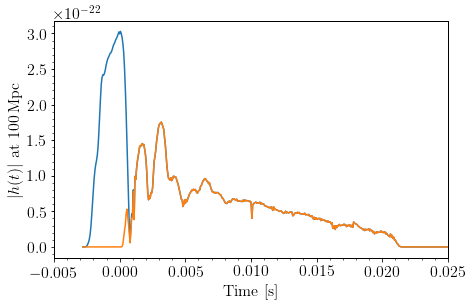

In [115]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(time, amplitude, label=r'$\textrm{Full merger}$')
ax.plot(time, amplitude_post, label=r'$\textrm{Post merger}$')
ax.set_xlim(-0.005,0.025)

ax.set_xlabel(r'$\textrm{Time [s]}$')
ax.set_ylabel(r'$|h(t)|\textrm{ at 100\,Mpc}$')

ax.minorticks_on()

plt.savefig("{}-AmplitudeEnvelope.pdf".format(wavelabel))

plt.show()

##### Instantaneous Frequency

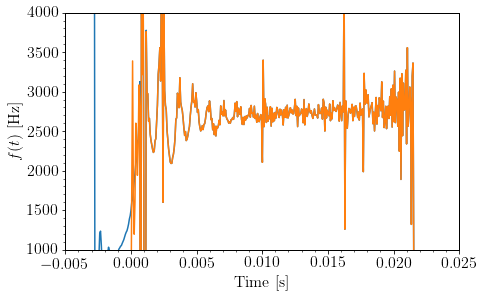

In [116]:
fig, ax = plt.subplots(figsize=fig_size)

ax.plot(time[:-1], frequency, label=r'$\textrm{Full merger}$')
ax.plot(time[:-1], frequency_post, label=r'$\textrm{Post merger}$')
ax.set_xlim(-0.005,0.025)
ax.set_ylim(1000,4000)

ax.set_xlabel(r'$\textrm{Time [s]}$')
ax.set_ylabel(r'$f(t)\textrm{ [Hz]}$')

ax.minorticks_on()

plt.savefig("{}-FrequencyEvolution.pdf".format(wavelabel))

plt.show()

## Time-Frequency Analysis
We will now analyze the signal in the time-frequency plane using spectrograms with different bases:
 * Fourier basis (traditional fixed resolution spectrogram)
 * Continuous wavelet transform
 * Q-transform (aka Q-scans, Omega-scans)
 * Prony Analysis


### Q-scans

In [87]:
hp_red = hp[:sample_frequency]
hp_red.data += 1e-28 * np.random.randn(len(hp_red))

dT=1./4096
logfsteps=1024
f_range=(1024,4096)
# q_range=(128,128)

On Q=4: 15.4248383086 [1/62]
On Q=6: 15.064589903 [2/62]
On Q=8: 14.9514620979 [3/62]
On Q=10: 14.9258762029 [4/62]
On Q=12: 14.9729430246 [5/62]
On Q=14: 15.0380931317 [6/62]
On Q=16: 15.0812421584 [7/62]
On Q=18: 15.0878720132 [8/62]
On Q=20: 15.0634034819 [9/62]
On Q=22: 15.0058932165 [10/62]
On Q=24: 14.9335845031 [11/62]
On Q=26: 14.8429226741 [12/62]
On Q=28: 14.7418825319 [13/62]
On Q=30: 14.644397633 [14/62]
On Q=32: 14.5639775825 [15/62]
On Q=34: 14.4802806402 [16/62]
On Q=36: 14.3858194791 [17/62]
On Q=38: 14.2986999891 [18/62]
On Q=40: 14.1874580243 [19/62]
On Q=42: 14.1145398692 [20/62]
On Q=44: 14.0351179725 [21/62]
On Q=46: 13.9550313475 [22/62]
On Q=48: 13.8771097318 [23/62]
On Q=50: 13.7753648854 [24/62]
On Q=52: 13.7895225069 [25/62]
On Q=54: 13.7247996127 [26/62]
On Q=56: 13.651256434 [27/62]
On Q=58: 13.6303814248 [28/62]
On Q=60: 13.5896586355 [29/62]
On Q=62: 13.5329518366 [30/62]
On Q=64: 13.4566500995 [31/62]
On Q=66: 13.4188849342 [32/62]
On Q=68: 13.445610195 [

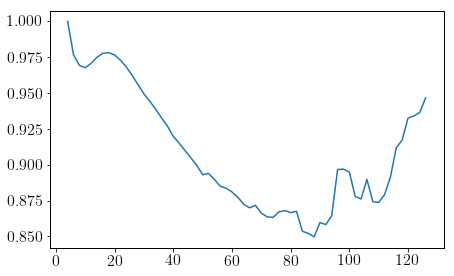

In [88]:
# --- Shannon entropy
from skimage.measure import shannon_entropy

# from skimage.morphology import disk
# from skimage.filters.rank import entropy

# from scipy.stats import entropy as scipy_entropy
# def shannon_entropy(image, base=2):
#     _, counts = np.unique(image, return_counts=True)
#     return scipy_entropy(counts, base=base)
# from PIL import Image

shannon=[]
Qs = np.arange(4, 128, 2)
for q,Q in enumerate(Qs):
    
    q_range=(Q,Q)
    qtimes, qfreqs, qplane = hp_red.qtransform(dT, logfsteps=logfsteps, 
                                               qrange=q_range,
                                               frange=f_range)
#     qplane /= qplane.max()
    
    shannon.append(shannon_entropy(qplane))
#     shannon.append(entropy(qplane, disk(10)).sum())
#     qim = Image.fromarray(qplane)
#     shannon.append(shannon_entropy(qim))

    print "On Q={0}: {1} [{2}/{3}]".format(Q, shannon[q], q+1, len(Qs))
    
plt.figure()
# plt.plot(Qs, shannon/max(shannon))
plt.plot(Qs, shannon/max(shannon))
plt.show()
    

In [89]:
# --- Final Qscan    

Q0 = Qs[np.argmin(shannon)]
Q0 = 16

qtimes, qfreqs, qplane = hp_red.qtransform(dT, logfsteps=logfsteps, 
                                           qrange=(Q0,Q0),
                                           frange=f_range)
qplane /= qplane.max()

qtimes -= hp_red.sample_times[np.argmax(abs(hp_red))]

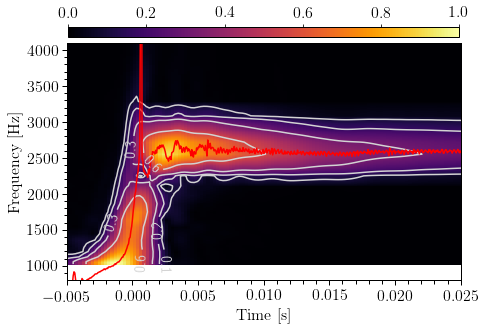

In [90]:
fig, ax = plt.subplots(figsize=fig_size)

p_qstrain = ax.pcolormesh(qtimes, qfreqs, np.sqrt(abs(qplane)),
                          cmap='inferno', rasterized=False,
                         vmin=0,vmax=1)

c_qstrain = ax.contour(qtimes, qfreqs, np.sqrt(abs(qplane)), 
            colors='lightgray', levels=np.logspace(-1,0,5))


cbaxes = fig.add_axes([0.1275, 0.9, 0.77, 0.03]) 
cbar=fig.colorbar(p_qstrain, orientation='horizontal', cax=cbaxes)

cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax.set_xlim(-0.005,0.025)
ax.set_ylim(800,4096)


ax.plot(time[:-1], frequency, color='r')

ax.set_xlabel(r'$\textrm{Time [s]}$')
ax.set_ylabel(r'$\textrm{Frequency [Hz]}$')
ax.clabel(c_qstrain, inline=1, fmt="%.1f", fontsize=14)
ax.minorticks_on()

touchbox(ax)

plt.show()

### Continuous Wavelet Transform
Some notes on the time-frequency volume for wavelets:

For sample frequency $f_s$, wavelet scales $i \in 1\dots N$ and mother wavelet frequency $m_f$, the TF map frequencies $f_i$ are given by:
$$
f_i = \frac{f_s}{N} m_f \cdot i
$$

i.e., Frequency range covered by the map:
 * $f_{\mathrm{max}} = f_s m_f$
 * $f_{\mathrm{min}} = \frac{f_s m_f}{N}$

Large scale (i.e., strongly dilated) wavelets are required to get to low frequencies (few cycles)

Small scale wavelets (contracted) correspond to high frequencies




In [117]:
import cwt

# User input
mother_freq=6
max_scale=128

fmin=sample_frequency*mother_freq/max_scale
fmax=sample_frequency*mother_freq

print "CWT map will cover: [{0},{1}]".format(
    fmin, fmax)



CWT map will cover: [768,98304]


On Q=0.5: 14.2631164934 [1/62]
On Q=1.0: 14.2822936958 [2/62]
On Q=1.5: 14.4269011946 [3/62]
On Q=2.0: 14.5679903179 [4/62]
On Q=2.5: 14.7661715927 [5/62]
On Q=3.0: 14.854171618 [6/62]
On Q=3.5: 15.0225209487 [7/62]
On Q=4.0: 15.0685458448 [8/62]
On Q=4.5: 15.1394279721 [9/62]
On Q=5.0: 15.1620776027 [10/62]
On Q=5.5: 15.1922032737 [11/62]
On Q=6.0: 15.1952498488 [12/62]
On Q=6.5: 15.1659391158 [13/62]
On Q=7.0: 15.1410815323 [14/62]
On Q=7.5: 15.1457573429 [15/62]


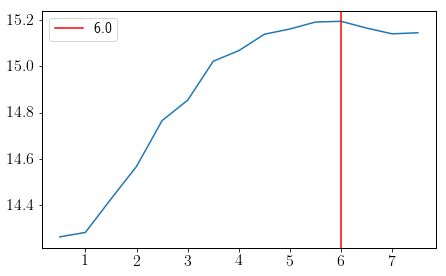

In [118]:
shannon = []
    
for q, Q in enumerate(np.arange(0.5, 8, 0.5)):
    
    # Compute the CWT
    cwt_result = cwt.build_cwt(hp_red.data, hp_red.sample_times, 
                               mother_freq=Q, max_scale=max_scale)
    wplane = cwt_result['map']

    shannon.append(shannon_entropy(wplane))

    print "On Q={0}: {1} [{2}/{3}]".format(Q, shannon[q], q+1, len(Qs))
    
plt.figure()
plt.plot(np.arange(0.5, 8, 0.5), shannon)
plt.axvline(np.arange(0.5, 8, 0.5)[np.argmax(shannon)], color='r', label=np.arange(0.5, 8, 0.5)[np.argmax(shannon)])
plt.legend()
plt.show()

In [119]:
# Compute the CWT

red_time = hp_red.sample_times - hp.sample_times[np.argmax(abs(hp_red))]

cwt_result = cwt.build_cwt(hp_red.data, hp_red.sample_times, 
                           mother_freq=mother_freq, max_scale=max_scale)
wtimes = np.copy(red_time)
wfreqs = cwt_result['frequencies']
wplane = cwt_result['map']

# Eliminate freqs > Nyquist
print "Decimating to Nyquist: [{}, {}]".format(
    fmin, sample_frequency/2)


from scipy.interpolate import interp1d
interpolant = interp1d(wfreqs, wplane, axis=0)
wfreqs = np.arange(wfreqs.min(), sample_frequency/2, 10)
wplane = interpolant(wfreqs)


Decimating to Nyquist: [768, 8192]


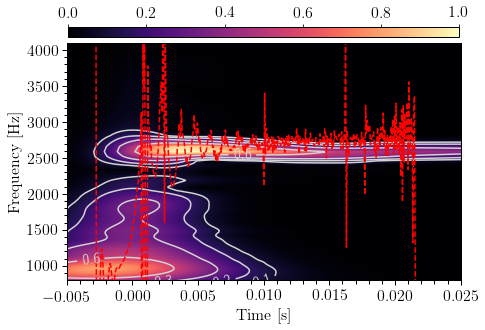

In [120]:
fig, ax = plt.subplots(figsize=fig_size)

p_qstrain = ax.pcolormesh(wtimes, wfreqs, (abs(wplane)),
                          cmap='magma', rasterized=False,
                         vmin=0,vmax=1)

c_qstrain = ax.contour(wtimes, wfreqs, (abs(wplane)), 
            colors='lightgray', levels=np.logspace(-1,0,5))

cbaxes = fig.add_axes([0.1275, 0.9, 0.77, 0.03]) 
cbar=fig.colorbar(p_qstrain, orientation='horizontal', cax=cbaxes)

cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax.set_xlim(-0.005,0.025)
ax.set_ylim(800,4096)

ax.plot(time[:-1], frequency, color='r', linestyle='--')

ax.set_xlabel(r'$\textrm{Time [s]}$')
ax.set_ylabel(r'$\textrm{Frequency [Hz]}$')
ax.clabel(c_qstrain, inline=1, fmt="%.1f", fontsize=14)
ax.minorticks_on()

touchbox(ax)

plt.show()


